# Brazil Coffee Supply Risk Analysis
Time Series Modeling, Seasonality, and Anomaly Detection

## 1. Data Extraction & Cleaning
Filtering coffee export data using NCM codes.


In [49]:
## data management
import pandas as pd 
df_2021 = pd.read_csv("data/EXP_2021.csv" , sep=';')
df_2021.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
0,2021,1,40169990,10,361,SP,1,817800,5353,5353,42235
1,2021,2,94035000,11,317,RS,1,1017700,487,49670,53961
2,2021,11,35051000,10,63,MG,7,1017500,144000,144000,99654
3,2021,4,61023000,11,249,SP,4,817600,14,5,1087
4,2021,2,82111000,11,63,RS,7,1017503,7708,1105,12488


In [50]:
## reading the rest of the files  and checking them 
df_2024 = pd.read_csv("data/EXP_2024.csv" , sep=';')
df_2025 = pd.read_csv("data/EXP_2025.csv" , sep=';')

print(df_2021.shape)
print(df_2024.shape)
print(df_2025.shape)

(1480295, 11)
(1603796, 11)
(1709746, 11)


In [51]:
## filtering based on the orders of the project
raw_codes = [9011110, 9011190, 9011200]
processed_codes = [9012100, 9012200]

all_codes = raw_codes + processed_codes

df_2021 = df_2021[df_2021['CO_NCM'].isin(all_codes)]
df_2024 = df_2024[df_2024['CO_NCM'].isin(all_codes)]
df_2025 = df_2025[df_2025['CO_NCM'].isin(all_codes)]

print(df_2021.shape)
print(df_2024.shape)
print(df_2025.shape)

(5697, 11)
(6890, 11)
(6878, 11)


In [52]:
## we further filter featuers based of what we use 
cols = ['CO_NCM', 'VL_FOB', 'KG_LIQUIDO', 'CO_ANO', 'CO_MES']

df_2021 = df_2021[cols]
df_2024 = df_2024[cols]
df_2025 = df_2025[cols]

df_2021.head()

,CO_NCM,VL_FOB,KG_LIQUIDO,CO_ANO,CO_MES
134,9012100,15,4,2021,2
159,9012100,37,6,2021,10
202,9011110,16893588,5257759,2021,11
203,9012100,3140,137,2021,12
220,9011110,2810701,842075,2021,10


## 2. Feature Engineering
Unit price 

In [53]:
## we define and set unit price here 
for df in [df_2021, df_2024, df_2025]:
    df["VL_FOB"] = pd.to_numeric(df["VL_FOB"], errors="coerce")
    df["KG_LIQUIDO"] = pd.to_numeric(df["KG_LIQUIDO"], errors="coerce")
    df["UNIT_PRICE"] = df["VL_FOB"] / df["KG_LIQUIDO"]

In [54]:
## getting unit price nice and clean 
for df in [df_2021, df_2024, df_2025]:
    df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    df.dropna(subset=["UNIT_PRICE"], inplace=True)
    df = df[df["UNIT_PRICE"] > 0]

In [55]:
## checking the unit price informations
df_2025["UNIT_PRICE"].describe()

count     6810.0
unique    5319.0
top         18.0
freq        29.0
Name: UNIT_PRICE, dtype: float64

In [56]:
## removing 0 prices,... alas ..., nothing is free in this world sadly ... :(
for df in [df_2021, df_2024, df_2025]:
    df.drop(df[df["UNIT_PRICE"] == 0].index, inplace=True)
    

## 3. time and date section

In [57]:
## time section
for df in [df_2021, df_2024, df_2025]:
    df["DATE"] = pd.to_datetime(df["CO_ANO"].astype(str) + "-" + df["CO_MES"].astype(str))


In [58]:
## as usuall , checking again , just to be sure
df_2025[["CO_ANO", "CO_MES", "DATE"]].head()

,CO_ANO,CO_MES,DATE
44,2025,9,2025-09-01
48,2025,11,2025-11-01
78,2025,10,2025-10-01
308,2025,3,2025-03-01
354,2025,3,2025-03-01


In [59]:
## monthly exports for raw coffe
raw_2025 = df_2025[df_2025["CO_NCM"].isin(raw_codes)]

raw_monthly_2025 = raw_2025.groupby("DATE").agg({
    "KG_LIQUIDO": "sum",
    "VL_FOB": "sum",
    "UNIT_PRICE": "mean"
}).sort_index()

raw_monthly_2025.head()

,KG_LIQUIDO,VL_FOB,UNIT_PRICE
DATE,,,
2025-01-01,245358789,1327424232,6.915925
2025-02-01,172110099,1032922273,7.991506
2025-03-01,219190204,1435207618,7.8242
2025-04-01,173080150,1249974397,10.393234
2025-05-01,170235073,1213337734,9.709122


In [60]:
## montly exports for precessed coffe 
proc_2025 = df_2025[df_2025["CO_NCM"].isin(processed_codes)]

proc_monthly_2025 = proc_2025.groupby("DATE").agg({
    "KG_LIQUIDO": "sum",
    "VL_FOB": "sum",
    "UNIT_PRICE": "mean"
}).sort_index()

proc_monthly_2025.head()

,KG_LIQUIDO,VL_FOB,UNIT_PRICE
DATE,,,
2025-01-01,457445,4437344,15.872306
2025-02-01,395930,3789170,16.761538
2025-03-01,362014,4227135,16.973244
2025-04-01,461503,4580414,17.359784
2025-05-01,380630,4327438,18.365926



## 4. 2025 export comparison of raw and processed coffe


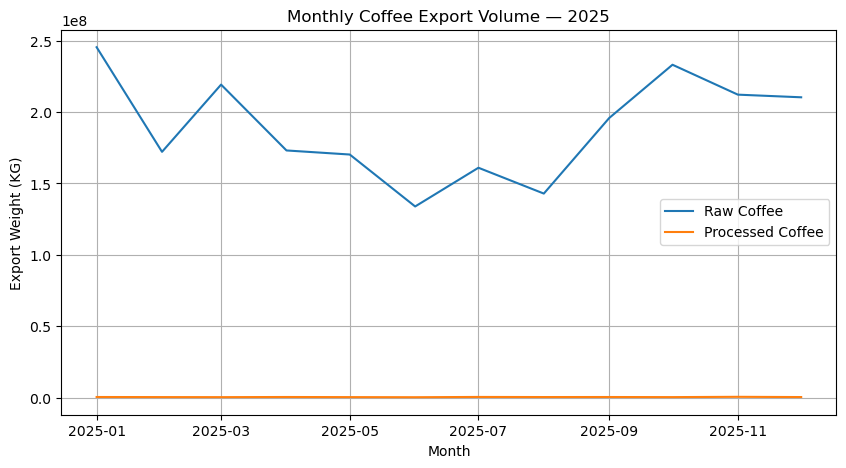

In [61]:
##now we check the volumes and plot them 
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(raw_monthly_2025.index, raw_monthly_2025["KG_LIQUIDO"], label="Raw Coffee")
plt.plot(proc_monthly_2025.index, proc_monthly_2025["KG_LIQUIDO"], label="Processed Coffee")

plt.title("Monthly Coffee Export Volume — 2025")
plt.xlabel("Month")
plt.ylabel("Export Weight (KG)")
plt.legend()
plt.grid(True)
plt.show()

## 5. raw coffe export compariosn for 2024 and 2025

In [62]:
raw_2024 = df_2024[df_2024["CO_NCM"].isin(raw_codes)]

raw_monthly_2024 = raw_2024.groupby("DATE")["KG_LIQUIDO"].sum().sort_index()


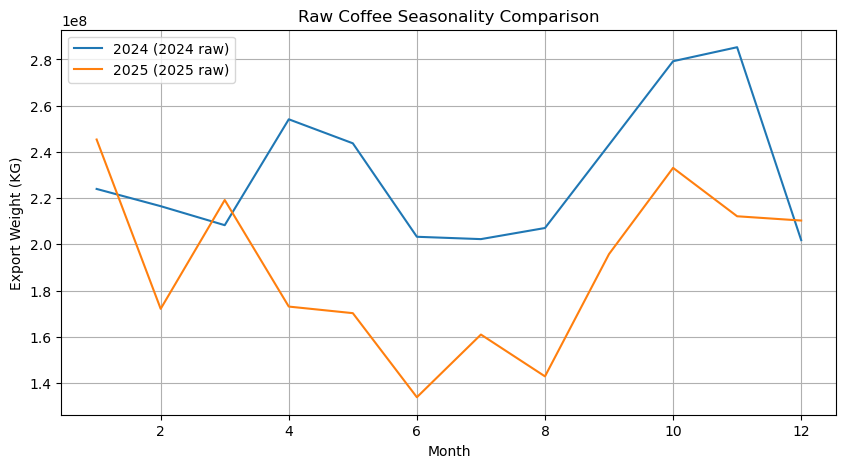

In [63]:
plt.figure(figsize=(10,5))

plt.plot(raw_monthly_2024.index.month, raw_monthly_2024, label="2024 (2024 raw)")
plt.plot(raw_monthly_2025.index.month, raw_monthly_2025["KG_LIQUIDO"], label="2025 (2025 raw)")

plt.title("Raw Coffee Seasonality Comparison")
plt.xlabel("Month")
plt.ylabel("Export Weight (KG)")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
## here we get the 2024 export sum of coffe per month
raw_2024 = df_2024[df_2024["CO_NCM"].isin(raw_codes)]

raw_monthly_2024 = raw_2024.groupby("DATE").agg({
    "KG_LIQUIDO": "sum"
}).sort_index()

In [65]:
## here we compare the exports of  2025 and 2024 on a monthly basis
season_compare = pd.DataFrame({
    "2024": raw_monthly_2024["KG_LIQUIDO"].values,
    "2025": raw_monthly_2025["KG_LIQUIDO"].values
}, index=raw_monthly_2025.index.month)

season_compare["Pct_Diff"] = (
    (season_compare["2025"] - season_compare["2024"]) /
    season_compare["2024"] * 100
)

season_compare

,2024,2025,Pct_Diff
DATE,,,
1,223975119,245358789,9.547342
2,216518756,172110099,-20.510305
3,208294949,219190204,5.230686
4,254108934,173080150,-31.887420
5,243720036,170235073,-30.151384
6,203278892,133862963,-34.148124
7,202266770,160973609,-20.415198
8,207071037,142886810,-30.996236
9,243101316,195803847,-19.455867


In [ ]:
## so based on chart comparison and the export diff between 2024 and 2025 , we can conclude that there are 4 monthes with around 30% reduction in export which clearly shows a shock  in raw coffe export,
##and since its a huge shock and extends to several monthes, it shows its not about seasonal difficulties,and clearly its a supply shock 

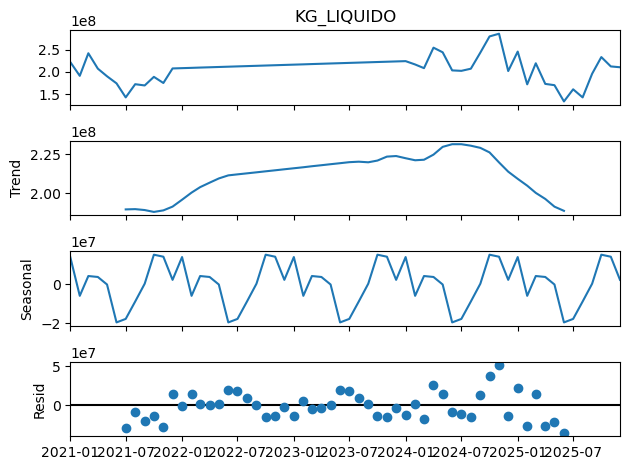

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

raw_series = raw_series.asfreq("MS")
raw_series = raw_series.interpolate()
decomp_raw = seasonal_decompose(raw_series, model='additive', period=12)
decomp_raw.plot();

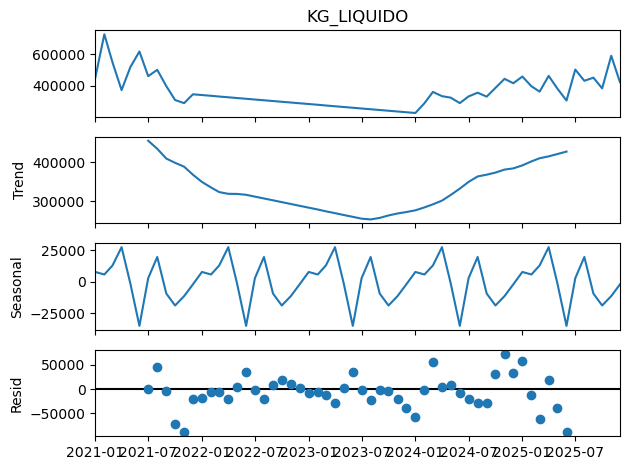

In [67]:

proc_series = pd.concat([
    df_2021[df_2021["CO_NCM"].isin(processed_codes)].groupby("DATE")["KG_LIQUIDO"].sum(),
    df_2024[df_2024["CO_NCM"].isin(processed_codes)].groupby("DATE")["KG_LIQUIDO"].sum(),
    df_2025[df_2025["CO_NCM"].isin(processed_codes)].groupby("DATE")["KG_LIQUIDO"].sum()
]).sort_index().asfreq("MS")
proc_series = proc_series.asfreq("MS")
proc_series = proc_series.interpolate()
decomp_proc = seasonal_decompose(proc_series, model='additive', period=12)
decomp_proc.plot();

In [ ]:
## as shown with the charts, we see the negative export around 2025  for raw coffe and then , as time goes on , it affects the processed coffe too eventually 

## 6. predicitng coffe exports for the first season of 2026

In [68]:
## now for 2026 predictions
## we combine raw monthly data
raw_2021 = df_2021[df_2021["CO_NCM"].isin(raw_codes)].groupby("DATE")["KG_LIQUIDO"].sum()
raw_2024 = df_2024[df_2024["CO_NCM"].isin(raw_codes)].groupby("DATE")["KG_LIQUIDO"].sum()
raw_2025 = raw_monthly_2025["KG_LIQUIDO"]

raw_series = pd.concat([raw_2021, raw_2024, raw_2025]).sort_index()
raw_series.index = pd.to_datetime(raw_series.index)
raw_series = raw_series.asfreq("MS")   # MS = Month Start

In [69]:
## using arima model 
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(raw_series, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=3)
forecast.index = pd.date_range("2026-01-01", periods=3, freq="MS")

forecast

2026-01-01    2.084924e+08
2026-02-01    2.097421e+08
2026-03-01    2.088791e+08
Freq: MS, Name: predicted_mean, dtype: float64

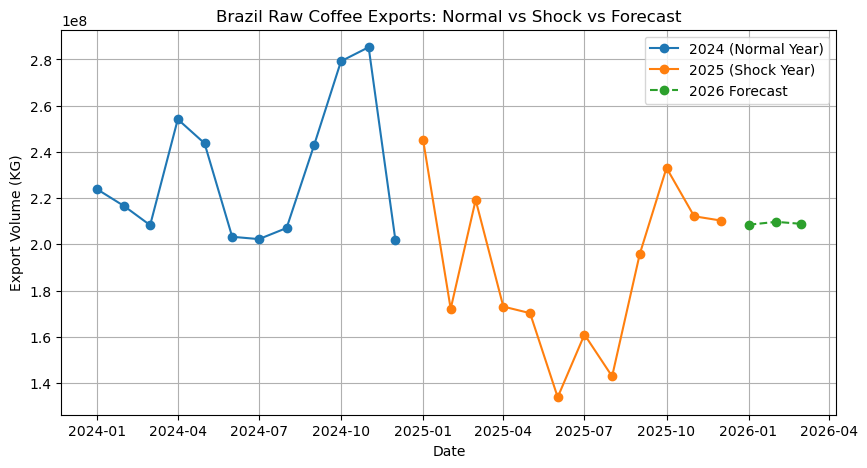

In [70]:
plt.figure(figsize=(10,5))

# 2024 actual
plt.plot(raw_monthly_2024.index, raw_monthly_2024["KG_LIQUIDO"],
         label="2024 (Normal Year)", marker='o')

# 2025 actual
plt.plot(raw_monthly_2025.index, raw_monthly_2025["KG_LIQUIDO"],
         label="2025 (Shock Year)", marker='o')

# 2026 forecast
plt.plot(forecast.index, forecast.values,
         label="2026 Forecast", linestyle="--", marker='o')

plt.title("Brazil Raw Coffee Exports: Normal vs Shock vs Forecast")
plt.xlabel("Date")
plt.ylabel("Export Volume (KG)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
##so , based on these results and charts, we can preditc around 10% t0 15% less export in the first season of 2026 which means the previous shock in 2025 has lingering effects but will become milder in the 2026 

## 7. frost shock section

In [71]:
##frost shock
##all of the raw coffe of 2021
raw_2021 = df_2021[df_2021["CO_NCM"].isin(raw_codes)] \
    .groupby("DATE")["KG_LIQUIDO"].sum().sort_index()

raw_2021 = raw_2021.asfreq("MS").interpolate()
mean_2021 = raw_2021.mean()
std_2021 = raw_2021.std()



In [72]:
mean_2021 = raw_2021.mean()
std_2021 = raw_2021.std()

z_scores = (raw_2021 - mean_2021) / std_2021
z_scores


DATE
2021-01-01    1.199173
2021-02-01    0.032811
2021-03-01    1.941290
2021-04-01    0.640070
2021-05-01   -0.004261
2021-06-01   -0.602093
2021-07-01   -1.787928
2021-08-01   -0.672853
2021-09-01   -0.780020
2021-10-01   -0.052449
2021-11-01   -0.571589
2021-12-01    0.657849
Freq: MS, Name: KG_LIQUIDO, dtype: float64

In [73]:
##only 9011110 code raw now
frost_code = 9011110

frost_2021 = df_2021[df_2021["CO_NCM"] == frost_code] \
    .groupby("DATE")["KG_LIQUIDO"].sum().sort_index()

frost_2021 = frost_2021.asfreq("MS").interpolate()

In [74]:
mean_frost = frost_2021.mean()
std_frost = frost_2021.std()

z_frost = (frost_2021 - mean_frost) / std_frost
z_frost

DATE
2021-01-01    1.199839
2021-02-01    0.032794
2021-03-01    1.941023
2021-04-01    0.640238
2021-05-01   -0.003921
2021-06-01   -0.602391
2021-07-01   -1.788334
2021-08-01   -0.671694
2021-09-01   -0.778747
2021-10-01   -0.056399
2021-11-01   -0.571090
2021-12-01    0.658683
Freq: MS, Name: KG_LIQUIDO, dtype: float64

In [75]:
##frost shock for rosted coffe( processed)
roasted_2021 = df_2021[df_2021["CO_NCM"] == 9012100]

roasted_monthly_2021 = roasted_2021.groupby("DATE")["KG_LIQUIDO"].sum()

roasted_z = (roasted_monthly_2021 - roasted_monthly_2021.mean()) / roasted_monthly_2021.std()

roasted_z

DATE
2021-01-01   -0.097802
2021-02-01    2.048873
2021-03-01    0.668582
2021-04-01   -0.689805
2021-05-01    0.431697
2021-06-01    1.204174
2021-07-01   -0.006685
2021-08-01    0.311703
2021-09-01   -0.493418
2021-10-01   -1.168677
2021-11-01   -1.313850
2021-12-01   -0.894793
Name: KG_LIQUIDO, dtype: float64

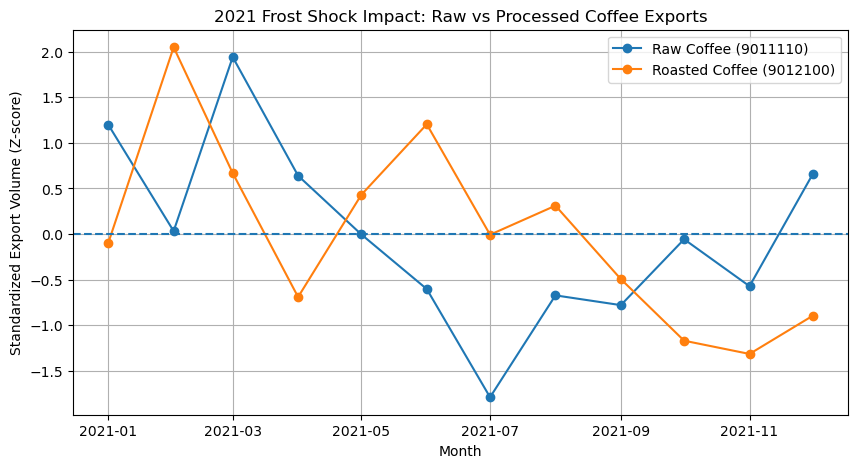

In [76]:
import matplotlib.pyplot as plt

# --- Raw coffee (9011110) ---
raw_2021 = df_2021[df_2021["CO_NCM"] == 9011110]
raw_monthly_2021 = raw_2021.groupby("DATE")["KG_LIQUIDO"].sum()
raw_z = (raw_monthly_2021 - raw_monthly_2021.mean()) / raw_monthly_2021.std()

# --- Processed coffee (9012100) ---
roasted_2021 = df_2021[df_2021["CO_NCM"] == 9012100]
roasted_monthly_2021 = roasted_2021.groupby("DATE")["KG_LIQUIDO"].sum()
roasted_z = (roasted_monthly_2021 - roasted_monthly_2021.mean()) / roasted_monthly_2021.std()

# --- Plot ---
plt.figure(figsize=(10,5))

plt.plot(raw_z.index, raw_z, marker='o', label="Raw Coffee (9011110)")
plt.plot(roasted_z.index, roasted_z, marker='o', label="Roasted Coffee (9012100)")

plt.axhline(0, linestyle="--")  # normal level
plt.title("2021 Frost Shock Impact: Raw vs Processed Coffee Exports")
plt.ylabel("Standardized Export Volume (Z-score)")
plt.xlabel("Month")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
##The anomaly detection approach successfully captures the 2021 frost disturbance.heavy shock on raw export while doing a milder shock on processed coffe ,might be because of companies used the stored beans 
##A notable negative deviation occurs in July 2021 for raw coffee exports, consistent with the timing of Brazil’s frost event. While not an extreme statistical outlier, the directional anomaly and temporal alignment support the model’s ability to capture real supply disruptions.
## Frost events do not eliminate exports instantly; instead, they create supply uncertainty, quality losses, and inventory hoarding behavior, leading to observable mid-year export slowdowns.

## 8. fraud and anomaly detection in 2025

In [77]:
data_2025 = df_2025[["CO_NCM", "KG_LIQUIDO", "VL_FOB", "UNIT_PRICE"]].copy()

In [78]:

from sklearn.ensemble import IsolationForest
import numpy as np


df_2025["UNIT_PRICE"] = df_2025["VL_FOB"] / df_2025["KG_LIQUIDO"]

df_2025["LOG_WEIGHT"] = np.log1p(df_2025["KG_LIQUIDO"])
df_2025["LOG_VALUE"]  = np.log1p(df_2025["VL_FOB"])
df_2025["LOG_PRICE"]  = np.log1p(df_2025["UNIT_PRICE"])

features = df_2025[["LOG_WEIGHT", "LOG_VALUE", "LOG_PRICE"]]


model = IsolationForest(
    n_estimators=200,
    contamination=0.01,
    random_state=42
)

df_2025["ANOMALY"] = model.fit_predict(features)  # -1 = anomaly


def label_anomaly(row):
    if row["ANOMALY"] != -1:
        return "Normal Trade"
    
    if row["KG_LIQUIDO"] < 50:
        return "Micro Shipment / Admin Record"
    
    elif row["UNIT_PRICE"] < 4:
        return "Unreasonably Low Price"
    
    elif row["UNIT_PRICE"] > 20:
        return "Unreasonably High Price"
    
    else:
        return "Normal Trade"

df_2025["ANOMALY_TYPE"] = df_2025.apply(label_anomaly, axis=1)


anomaly_table = df_2025[
    df_2025["ANOMALY_TYPE"] != "Normal Trade"
][[
    "CO_NCM",
    "KG_LIQUIDO",
    "VL_FOB",
    "UNIT_PRICE",
    "ANOMALY_TYPE"
]]

anomaly_table.head(10)

,CO_NCM,KG_LIQUIDO,VL_FOB,UNIT_PRICE,ANOMALY_TYPE
89674,9012100,1,1,1.000000,Micro Shipment / Admin Record
132840,9012100,7,8,1.142857,Micro Shipment / Admin Record
167275,9012200,1,2,2.000000,Micro Shipment / Admin Record
225136,9012100,10,12,1.200000,Micro Shipment / Admin Record
254700,9012100,12,16,1.333333,Micro Shipment / Admin Record
283152,9012200,6,7,1.166667,Micro Shipment / Admin Record
284277,9012200,3,6,2.000000,Micro Shipment / Admin Record
301453,9012200,1,1,1.000000,Micro Shipment / Admin Record
313823,9011110,175,41300,236.000000,Unreasonably High Price
394299,9012100,11,14,1.272727,Micro Shipment / Admin Record


In [79]:
df_all = pd.concat([df_2021, df_2024, df_2025], ignore_index=True)

df_all["UNIT_PRICE"] = df_all["VL_FOB"] / df_all["KG_LIQUIDO"]

import numpy as np
df_all["LOG_WEIGHT"] = np.log1p(df_all["KG_LIQUIDO"])
df_all["LOG_VALUE"]  = np.log1p(df_all["VL_FOB"])
df_all["LOG_PRICE"]  = np.log1p(df_all["UNIT_PRICE"])

In [80]:
from sklearn.ensemble import IsolationForest

features = df_all[["LOG_WEIGHT", "LOG_VALUE", "LOG_PRICE"]]

model = IsolationForest(
    n_estimators=200,
    contamination=0.01,
    random_state=42
)

df_all["ANOMALY"] = model.fit_predict(features)

In [81]:
df_clean = df_all[
    (
        (df_all["UNIT_PRICE"].between(0.1, 30)) &  # price range
        (df_all["KG_LIQUIDO"] >= 0.1)              # the cargo size
    )
]

In [82]:
print("Before cleaning:", len(df_all))
print("After cleaning:", len(df_clean))

Before cleaning: 19331
After cleaning: 18406


In [83]:
print("Original mean price:", df_all["UNIT_PRICE"].mean())
print("Clean mean price:", df_clean["UNIT_PRICE"].mean())

print("Original min price:", df_all["UNIT_PRICE"].min())
print("Clean min price:", df_clean["UNIT_PRICE"].min())

print("Original max price:", df_all["UNIT_PRICE"].max())
print("Clean max price:", df_clean["UNIT_PRICE"].max())

Original mean price: 9.478844405046358
Clean mean price: 7.423121203574792
Original min price: 0.0033333333333333335
Clean min price: 0.2
Original max price: 539.5
Clean max price: 30.0


In [84]:
monthly_original = df_all.groupby("DATE")["KG_LIQUIDO"].sum()
monthly_clean = df_clean.groupby("DATE")["KG_LIQUIDO"].sum()

comparison = pd.DataFrame({
    "Original": monthly_original,
    "Clean": monthly_clean
})

comparison.head(12)

,Original,Clean
DATE,,
2021-01-01,222415786,222414960
2021-02-01,191824312,191822954
2021-03-01,242152317,242151651
2021-04-01,207541686,207541324
2021-05-01,190635363,190607061
2021-06-01,174913111,174913065
2021-07-01,143374832,143374615
2021-08-01,172924398,172923917
2021-09-01,169985091,169985017


In [85]:
monthly_clean = df_clean.groupby("DATE")["KG_LIQUIDO"].sum().asfreq("MS")

model_arima = ARIMA(monthly_clean, order=(1,1,1))
results = model_arima.fit()

forecast_2026_clean = results.forecast(steps=3)
forecast_2026_clean

2026-01-01    2.089821e+08
2026-02-01    2.101842e+08
2026-03-01    2.093538e+08
Freq: MS, Name: predicted_mean, dtype: float64

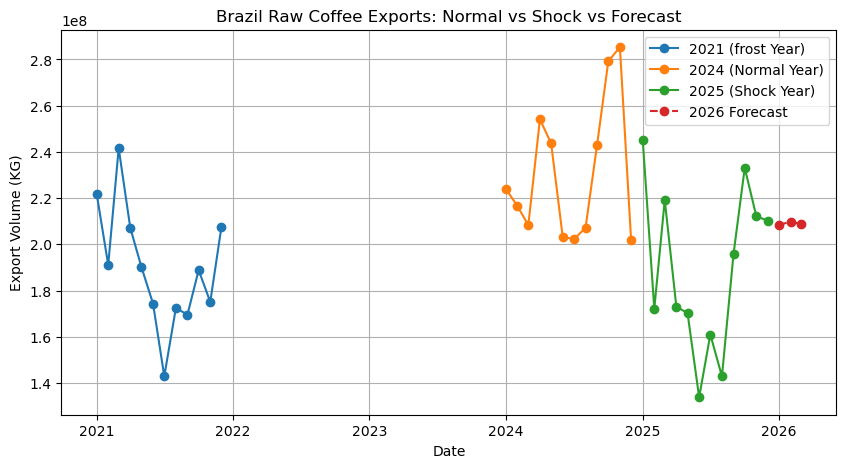

In [88]:
plt.figure(figsize=(10,5))

raw_2021 = df_2021[df_2021["CO_NCM"].isin(raw_codes)]

raw_monthly_2021 = raw_2021.groupby("DATE").agg({
    "KG_LIQUIDO": "sum",
    "VL_FOB": "sum",
    "UNIT_PRICE": "mean"
}).sort_index()



#2021 actual 
plt.plot(raw_monthly_2021.index, raw_monthly_2021["KG_LIQUIDO"],
         label="2021 (frost Year)", marker='o')
# 2024 actual
plt.plot(raw_monthly_2024.index, raw_monthly_2024["KG_LIQUIDO"],
         label="2024 (Normal Year)", marker='o')

# 2025 actual
plt.plot(raw_monthly_2025.index, raw_monthly_2025["KG_LIQUIDO"],
         label="2025 (Shock Year)", marker='o')

# 2026 forecast
plt.plot(forecast.index, forecast.values,
         label="2026 Forecast", linestyle="--", marker='o')

plt.title("Brazil Raw Coffee Exports: Normal vs Shock vs Forecast")
plt.xlabel("Date")
plt.ylabel("Export Volume (KG)")
plt.legend()
plt.grid(True)
plt.show()